In [83]:
#@title Установка (при начале сеанса Colab) { form-width: "20%", display-mode: "form" }
instal = False #@param {type:"boolean"}
#@markdown Дополнительные библиотеки:
#@markdown 1. Pandas Profiling - первичный осмотр датафрейма
#@markdown 1. imbalanced-learn - для рботы с несбалансированными данными

#@markdown После установки - перезапустить среду выполнения


if instal == True:
    '''
    Colab включает старую версию pandas-profiling, поэтому необходимо обновиться:
    '''
    import sys
    !{sys.executable} -m pip install -U pandas-profiling[notebook]
    !jupyter nbextension enable --py widgetsnbextension

    !pip install -U imbalanced-learn

In [84]:
# #@title imbalanced-learn { form-width: "20%", display-mode: "form" }
# #@markdown Установка дополнительных библиотек (при начале сеанса Colab)

# #@markdown После установки - перезапустить среду выполнения

# instal = False #@param {type:"boolean"}
# if instal == True:
#     '''Установка imbalanced-learn'''
#     !pip install -U imbalanced-learn

In [85]:
#@title Импорт библиотек { run: "auto", vertical-output: true, form-width: "20%", display-mode: "form" }
import time
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_theme(style="darkgrid")

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import balanced_accuracy_score, f1_score

from sklearn.preprocessing import PolynomialFeatures

# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [86]:
#@title Функции { run: "auto", form-width: "10%", display-mode: "form" }


def define_featyre_type(df):
    '''
    Определяет тип признака
    '''
    i = 0
    all_rows = len(df)
    for col in df.columns:
        s = ''
        s += col
        u = df[col].nunique()

        # % пропущенных 
        empty_rows = np.count_nonzero(df[col].isnull())
        p = round(empty_rows/all_rows*100,2)

        t = type(df[col][0])
        l = pd.unique(df[col].values.ravel())

        if (u <= 2):
            s += ': бинарный признак ' + str(l)
        elif t == str or u <= 8: # min кол-во значений признака
            s += ': категориальный признак ' + str(l)
        else:
            s += ': числовой признак'

        i += 1
        print(f'{i} {s}, {p}% пропусков')


def get_list_feature_type(df, kind):
    '''
    Воззвращает список имен колонок требуемого типа
    kind = 'bin' - бинарные
    kind = 'cat' - категориальные
    kind = 'num' - номинативные
    '''
    list_col = []
    for col in df.columns:

        u = df[col].nunique()
        t = type(df[col][0])

        if kind == 'bin':
             if (u <= 2):
                list_col.append(col)
        if kind == 'cat':
            if (t == str and u > 2) or (u > 2 and u < 8):
                list_col.append(col)
        if kind == 'num':
            if (t != str and u > 8):
                list_col.append(col)
    return (list_col)


def features_labelencoder(df,list_category=[], pref='le_'):
    '''
    label-кодирование категориальных признаков по списку
    '''
    for col in list_category:
        le = LabelEncoder()
        le.fit(df[col])
        df[pref + col] = le.transform(df[col])
    return (df)


def show_frequency(df,target,list_col,calculation_type='column'):
    '''
    Частотная диаграмма списка признаков для целевого параметра
    col_hue - целевой признак
    list_col - список признаков
    calculation_type - способ рассчёта:
        ='target' - группировка по значениям целевой переменной
                                (% от общей суммы по столбцу)
        ='column' - группирвка по значениям списка признаков
                                (% от общей суммы по строке)
        ='total' - % от общей суммы признака
    '''
    if calculation_type not in ['target','column','total']: 
        return

    n = len(list_col) // 2

    if n*2 < len(list_col): 
        n+=1

    fig, axes = plt.subplots(2, n, figsize=(n*7.5, 10))
    mainDf = df.copy()
    mainDf['frequency'] = 0

    for col, ax in zip(list_col, axes.flatten()):
        counts = mainDf.groupby([col, target]).count()

        if calculation_type == 'target':
            freq = counts.div(
                counts.groupby(target).transform('sum')
                ).reset_index()
        elif calculation_type == 'column':
            freq = counts.div(
                counts.groupby(col).transform('sum')
                ).reset_index()
        elif calculation_type == 'total':
            freq = counts.div(total).reset_index()

        sns.barplot(x=col, y='frequency', hue=target, data=freq, ax=ax)       


def get_boxplot(df, col1, col2, hue=None, orientation="h"):
    '''
    Function is called to plot boxplots
    '''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, 
                y=col2, 
                hue=hue, 
                data=df,
                orient=orientation,
                whis=1.5,
                palette="Set2")
    
    plt.xticks(rotation=45)
    ax.set_title(f'Boxplot for {col1} and {col2}', fontsize=14)
    plt.show()


def feature_to_cat(val,list_group=[]):
    '''
    Функция присваивает числовым признакам группу по заданным границам,
    т.о. числовой признак переводится в категориальный

    val - числовое значение
    list_group - список значений-границ групп в категории
    '''

    if len(list_group) > 0:
        for i, n in enumerate(list_group):
            if n != list_group[-1]:
                if val < n: 
                    break
            elif val < n: 
                break
            else: 
                i += 1
                break
        return i



def get_metrics(data, clf, X_test, y_true, model_name):
    '''Create and add metrics into a pandas DF after experiment'''

    y_score = clf.decision_function(X_test)
    report = pd.DataFrame(columns={'LogLoss'}, data=[0])

    # report['LogLoss'] = round(log_loss(y_true, clf.predict(X_test)),3)
    report['LogLoss'] = round(log_loss(y_true, 
                                       clf.predict_proba(X_test)),3)
    report['ROC-AUC'] = round(roc_auc_score(y_test,
                                      clf.predict_proba(X_test)[:, 1]),3)
    report['Balanced accuracy'] = round(balanced_accuracy_score(y_true, y_pred),3)
    report['Average precision'] = round(average_precision_score(y_true, y_score),3)
    # report['PR-AUC'] = precision_score(y_test,clf.predict(X_test))
    report['F1-score'] = round(f1_score(y_true, clf.predict(X_test)),3)

    report.index = [model_name]
    data = data.append(report)
    return data



def get_model_plot(model, X, y):
    '''
    Строим:
    кривую Precision-Recall, считаем среднюю точность (AP)
    ROC-кривую, считаем площадь под кривой (AUC)
    confusion matrix
    '''
    labels = ['Default','Not default']
    autopct='%.2f'
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    fig.subplots_adjust(wspace=0.1)
    plot_precision_recall_curve(model, X, y, ax=ax1)
    plot_roc_curve(model, X, y, ax=ax2)
    plot_confusion_matrix(model, X, y,
                          labels=[1,0],
                          display_labels=labels,
                          values_format='',
                          cmap='Blues',
                          ax=ax3)
    orig = pd.DataFrame(y,columns=[labels[0]])
    orig.Default.value_counts().plot.pie(autopct=autopct,
                                         explode=[0, 0.1],
                                         ax=ax4)
    ax4.set_title("Баланс классов")
    plt.show()


def get_class_balance(y, y_res, name='Сбалансированная выборка'):
    '''
    Визуализация оригинальной и сбалансированной выборки
    '''
    labels = ['Default']
    autopct='%.2f'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    fig.subplots_adjust(wspace=0.1)
    orig = pd.DataFrame(y,columns=['Default'])
    res = pd.DataFrame(y_res,columns=['Default'])
    orig.Default.value_counts().plot.pie(autopct=autopct,
                                         explode=[0, 0.1],
                                         ax=ax1)
    res.Default.value_counts().plot.pie(autopct=autopct,
                                        explode=[0, 0.1],
                                        ax=ax2)
    ax1.set_title(f'Оригинальная выборка\n {len(orig)} значений')
    ax2.set_title(f'{name}\n {len(res)} значений')
    plt.show()

In [87]:
#@title DATA { run: "auto", vertical-output: true, form-width: "10%" }

train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
display('train',train.sample(2),'test',test.sample(2))

'train'

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
35476,65666,14MAR2014,GRD,M,28,N,N,1,1,-1.987871,2,40,1,2,36000,1,2,N,0
70654,23706,30JAN2014,SCH,M,39,Y,N,0,0,-2.160658,5,80,2,3,55000,4,2,N,0


'test'

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
27135,41964,18FEB2014,GRD,M,32,Y,N,0,1,-2.275563,0,40,1,2,49000,1,4,N
14913,55266,04MAR2014,SCH,M,37,Y,N,3,0,-1.229331,0,50,2,3,40000,1,2,N


In [88]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [91]:
#@title Объединение train и test { run: "auto", vertical-output: true, form-width: "20%" }

# Помечаем train и test 
train['sample'] = 1
test['sample'] = 0

# в тесте нет значения default, мы его должны предсказать, по-этому заполняем нулями
test['default'] = 0 

df = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [92]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


## Описание полей датасета


№|Признак|Значение
:-:|:-|:-
1|client_id|идентификатор клиента
2|app_date|дата подачи заявки
3|education|уровень образования
4|sex|пол заёмщика
5|age|возраст заёмщика
6|car|флаг наличия автомобиля
7|car_type|флаг автомобиля-иномарки
8|decline_app_cnt|количество отказанных прошлых заявок
9|good_work|флаг наличия «хорошей» работы
10|score_bki|скоринговый балл по данным из БКИ
11|bki_request_cnt|количество запросов в БКИ
12|region_rating|рейтинг региона
13|home_address|категоризатор домашнего адреса
14|work_address|категоризатор рабочего адреса
15|income|доход заёмщика
16|sna|связь заемщика с клиентами банка
17|first_time|давность наличия информации о заемщике
18|foreign_passport|наличие загранпаспорта
19|default|наличие дефолта


# Предобработка
>* *Первичный осмотр*
* *Очистка*
* *Обработка пропусков*

В датасете есть параметр, выраженный датой - `app_date`.
Переведем его в формат даты

In [93]:
df.app_date = pd.to_datetime(df.app_date, dayfirst=True)

Используем [pandas profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/pages/advanced_usage.html)

In [94]:
#@title Pandas Profiling Report { vertical-output: true, form-width: "40%", display-mode: "form" }
get_report = False #@param {type:"boolean"}

if get_report==True:
    
    from pandas_profiling import ProfileReport

    profile = ProfileReport(df, title='Pandas Profiling Report', progress_bar=False) # 
    profile.to_notebook_iframe() # развёрнутый вид
    # profile.to_widgets() # компактный вид
    # profile.to_file("report.html") # в файл

## Распределение целевой переменной

Наша цель - предсказание перемнной `default` (1 или 0).

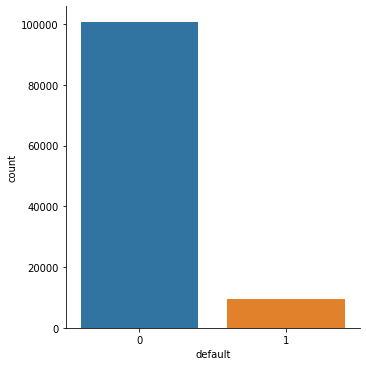

In [95]:
sns.catplot(x="default", kind="count", data=df);

Дефолтных клиентов значительно меньше. Для банка это хорошо, для модели - не очень. Такой дисбаланс даннных необходимо учесть в дальннейшем.

## Пропуски

Пропуски есть только в признаке **education**. Их не много - 0.43% от общего количества. Целесобразно заполнить.


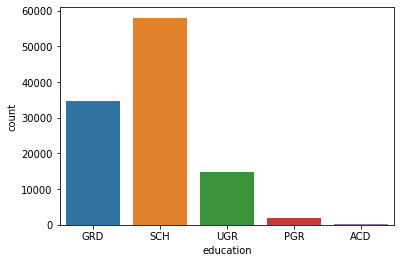

In [96]:
sns.countplot(x = 'education', data = df);

Заменяем пропуски наиболее частым значением

In [97]:
top = df.education.describe()['top']
df.education = df.education.fillna(top)

Оцениваем признаки, чтобы разделить их на бинарные, категориальные и числовые - для дальнейшей обработки

In [98]:
define_featyre_type(df)

1 client_id: числовой признак, 0.0% пропусков
2 app_date: числовой признак, 0.0% пропусков
3 education: категориальный признак ['GRD' 'SCH' 'UGR' 'PGR' 'ACD'], 0.0% пропусков
4 sex: бинарный признак ['M' 'F'], 0.0% пропусков
5 age: числовой признак, 0.0% пропусков
6 car: бинарный признак ['Y' 'N'], 0.0% пропусков
7 car_type: бинарный признак ['Y' 'N'], 0.0% пропусков
8 decline_app_cnt: числовой признак, 0.0% пропусков
9 good_work: бинарный признак [0 1], 0.0% пропусков
10 score_bki: числовой признак, 0.0% пропусков
11 bki_request_cnt: числовой признак, 0.0% пропусков
12 region_rating: категориальный признак [50 40 80 60 70 20 30], 0.0% пропусков
13 home_address: категориальный признак [1 2 3], 0.0% пропусков
14 work_address: категориальный признак [2 3 1], 0.0% пропусков
15 income: числовой признак, 0.0% пропусков
16 sna: категориальный признак [1 4 2 3], 0.0% пропусков
17 first_time: категориальный признак [4 3 1 2], 0.0% пропусков
18 foreign_passport: бинарный признак ['N' 'Y'], 0.0%

Составим списки категориальных, бинарных и числовых признаков.

In [99]:
cat_cols = get_list_feature_type(df,kind='cat') # Категориальные
bin_cols = get_list_feature_type(df,kind='bin') # Бинарные
num_cols = get_list_feature_type(df,kind='num') # Числовые

# Исключим из списка бинарных признаков `default` 
# и `sample` (маркер для train и test)
for l in ['default','sample']: bin_cols.remove(l)

# Из числа номинативных признаков исключим app_date (позже из него сосздадим новые)
# и client_id - все значения уникальные
for l in ['app_date','client_id']: num_cols.remove(l)

## ИТОГИ


* Данные полные, пропуски заполнены
* Данные представлены в формате дат, строк и чисел
* Охватывают первый квартал 2014 года (120 дней)
* По типу данные можно разделить на:
   * бинарные (выражены числами и строками)
   * категориальные (выражены так же числами и строками)
   * числовые
* В распределении целевой переменной имеется дисбаланс

Возможно постороение модели

1. Обзор датасета от Pandas Profiling [report.html](https://drive.google.com/file/d/1FRJmAQ1n91xsx-T5vMF7qM56gnB3F_mT/view?usp=sharing)

1. Данные содержат 19 параметров (исключая технический признак "Sample")

2. Общее количество строк 110148

3. Пропущено данных 0.43% - исправлено

4. Нет дубликатов

5. `client_id` - 100% уникальных значений

6. `app_date` даты за первый квартал 2014 года (120 дней)

7. `education`включает 5 значений:
   * SCH (52%) - школа
   * GRD (31%) - магистратура
   * UGR (13%) - бакалавриат
   * PGR (1,7%) - аспирантура
   * ACD (0,3%) - ученая степень
   * nan (0,4%) - заполнено самым частым значением SCH

8. `sex`:
   * Женщины (56%)
   * Мужчины (44%)

9. `age` - это вещественная числовая переменная. Распределение смещено влево.
    * Минимум 21
    * Медиана 37
    * Среднее 39,2
    * Максимум 72
    * Межквартильный размах (IQR) 18
 
10. `car` - логическая переменная. 67% заемщиков не имеют машины.

11. `car_type` - это логическая переменная, которая показывает, есть ли у заемщика отечественный автомобиль или иномарка. У 81% заемщиков есть отечественные автомобили.

12. `dec_app_cnt` - это действительное числовое значение. Распределение смещено влево. Большинство значений (83%) имеют нулевое значение, что оправдано (это количество отказов в кредите, полученное ранее). Необходимо сгруппировать эти данные и преобразовать в категориальный признак.

13. `good_work` - логическая переменная. Только 16.6% имеют хорошую работу (жаль, что неизвестны критерии оценки).

14. `score_bki` - это вещественная числовая переменная. Это скоринговый балл БКИ. Имеет нормальное распределение и скорее всего уже как-то был нормализован или масштабирован.

15. `bki_request_cnt` - это вещественная числовая переменная (количество запросов в БКИ, которые совершил заёмщик)
    * Mean	2.00500236
    * Minimum	0
    * Maximum	53
Нулевые значения составляют 26.2% данных, что оправдано. Возможно этот параметр необходимо подвергнуть min-max нормализации

16. `region_rating` - похож на категориальный признак (градация с фиксированным шагом 10 от 20 до 80)

17. `home_address` - категориальный признак (3 значения)
18. `work_address` - категориальный признак (3 значения)

19. `income` (Доход) - cмещенное распределение с большим разбросом значений - от 1000 до 1 000 000. Необходимо преобразовать в категориальный признак 

20. `sna` (связь заемщика с клиентами банка) - категориальный признак (4 значения)
21. `first_time` (давность наличия информации о заемщике) - категориальный признак (4 значения)

22. `foreign_passport` - логическая переменная. 67% заемщиков имеют загранпаспорт

23. `default` - целевая перемнная (логическая). Данные несбалансированы

Построим на первоначальных данных наивную модель.
Сейчас отбросим признаки, которые требуют кодирования.

In [100]:
model = df.drop(['app_date','education','sex','car','car_type','foreign_passport'], axis=1)
model.sample(4)

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
12182,35104,56,0,0,-2.007793,1,50,2,3,120000,1,4,0,0
45834,87808,23,1,0,-1.365082,1,60,2,3,45000,1,1,1,0
40264,86906,31,0,0,-1.722068,2,60,2,3,25000,4,2,1,0
33694,101779,44,0,0,-2.764200,0,60,2,3,50000,1,4,0,0


**Какие метрики использовать для оценки качества модели?**

* Из-за того, что данные в целевой переменной несбалансированы (сильный дисбаланс в сторону "не-дефолтных" клиентов, то метрику $Accuracy$ без балансировки использовать не стоит.
* При дисбалансе классов лучше использовать метрику ***Balanced Accuracy***
* Нужно использовать метрики $Precision-Recall$ и $F1-score$
* Для измерения точности модели будем использовать **average precision score** - как среднюю точность всех различных вариантов порога (значения вероятнисти, которое отличает один класс от другого).




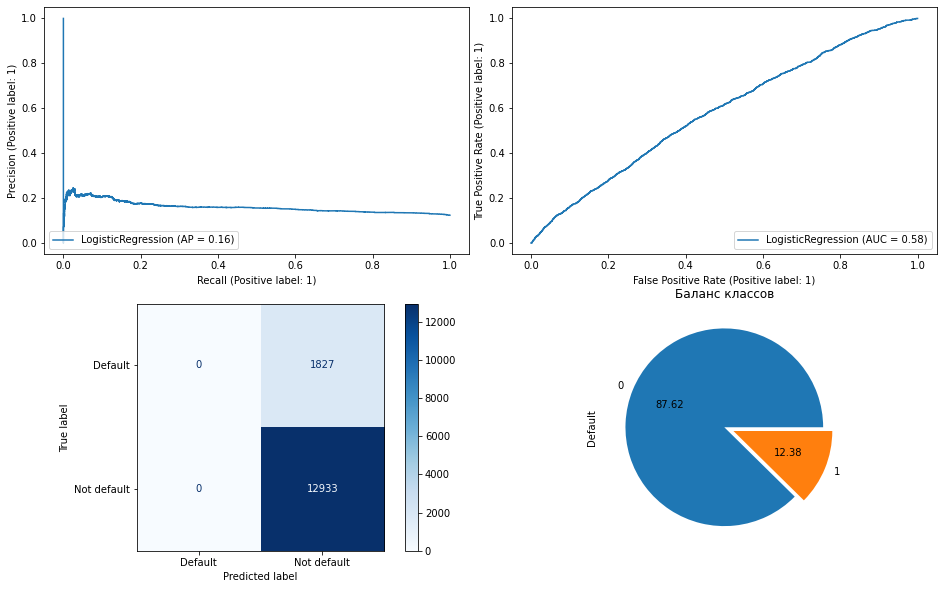

,LogLoss,ROC-AUC,Balanced accuracy,Average precision,F1-score
LogisticRegression_Naive,0.37,0.584,0.5,0.16,0.0


In [101]:
#@title Модель 1: наивная { run: "auto", form-width: "20%", display-mode: "form" }

# возвращаем данные в исходное состояние
train_data = model.query('sample == 1').drop(['sample','client_id'], axis=1)
test_data = model.query('sample == 0').drop(['sample','client_id'], axis=1)

X = train_data.drop(['default'], axis=1).values
y = train_data['default'].values

# Делим на обучающую и валидационнцю выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, 
                                                    random_state=RANDOM_SEED)

# Классифкатор
lr = LogisticRegression(max_iter = 1000)
# обучаем
lr.fit(X_train, y_train)
# предсказываем
y_pred = lr.predict(X_test)

# Визуализируем результат
get_model_plot(lr,X_test,y_test)

# Сохраним значения метрик
results = pd.DataFrame(data=None)
results = get_metrics(results, lr, X_test,
                       y_test, 'LogisticRegression_Naive')
results


* Эта наивная модель угадывает классы почти в 60% случаев, `ROC AUC` = 0.584
* Но угадывает только благополучных (не дефолтных) клиентов, которых в наших данных подавляющее большинство.
* График `Precision-Recall` говорит, что высокий процент правильных предсказаний (**Precision**) моделью достигается только при очень незначительном значении **Recall**, то есть она очень плохо классифицирует положительные данные (дефолтных клиентов). 
* Значения `Average precision ` и `F1-score` - очень низкие (чем выше, тем лучше).
* Logloss - должна стремится к 0



# EDA

## Числовые

Посмотрим на распределение

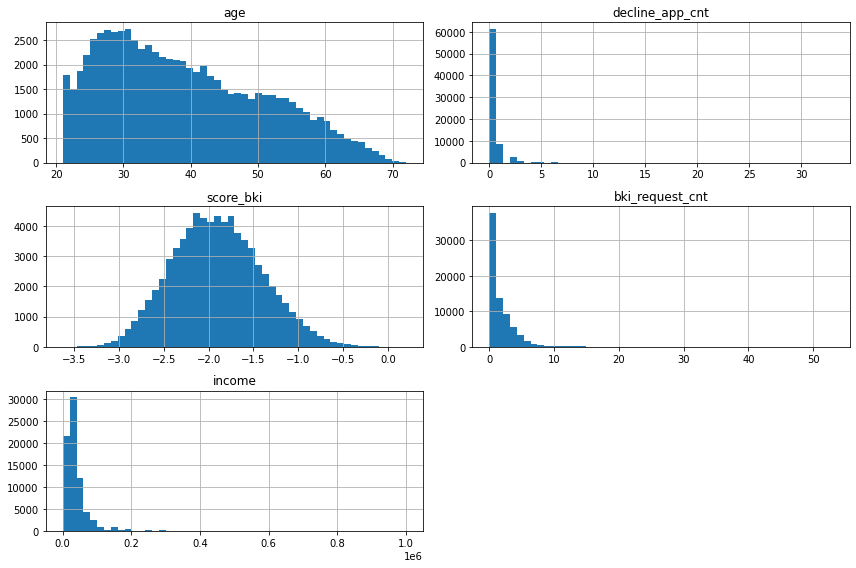

In [102]:
train[num_cols].hist(figsize=(12, 8), bins=50);
plt.tight_layout()

Из числовых признаков только `score_bki` имееет нормальное распределение (как уже отмечено выше - этот признак скорее всего уже был нормализован), у остальных - сильное левое смещение. Позже возможно применить к ним логарифмирование либо перевод в категориальный признак с дальнейшим кодированием.

Посмотрим на выбросы и связь этих перемнных с целевой

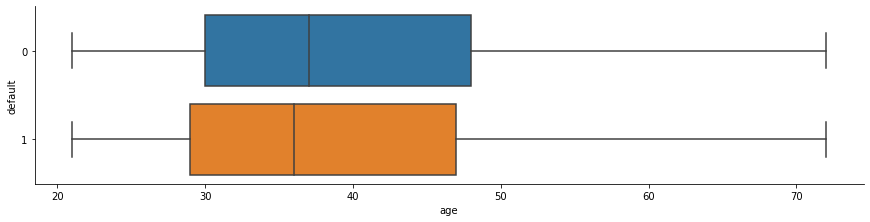

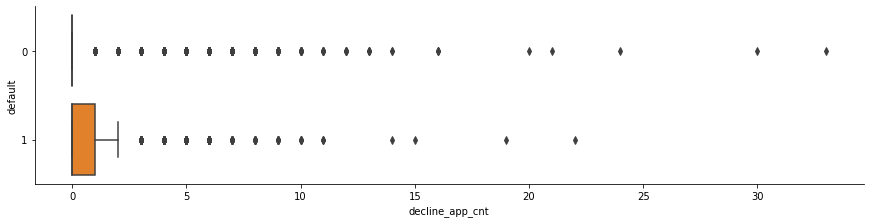

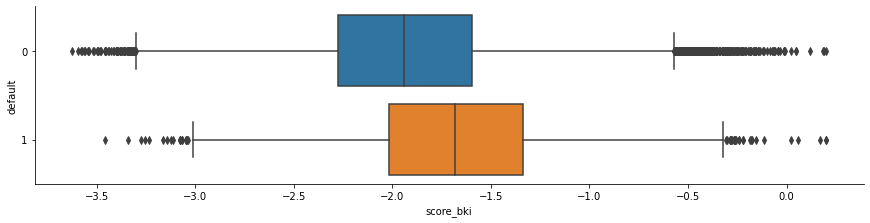

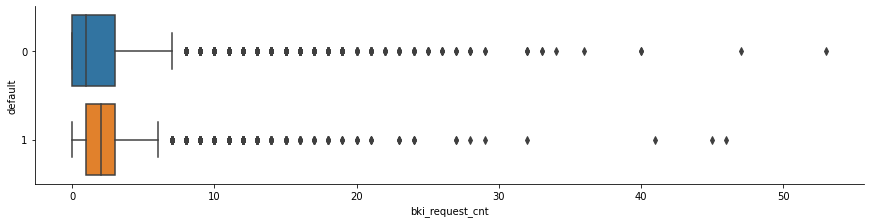

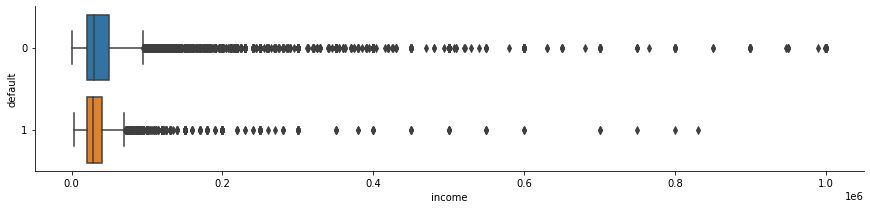

In [103]:
for col in num_cols:
    g = sns.catplot(y="default", x=col,data=df, kind="box", height=3, aspect=4, orient = 'h');

* Все параметры для дефолтных и не дефолтных клиентов отличаются - это хорошо для будущей модели
* age - выбросов нет, всё логично. Этот парметр в разразе дефолт/не дефолт наименее всех различается. Наверняка в этом виде он будет иметь наименьшее влияние на целевую переменную.
* В остальных параметрах формально выбросов много, то в действительности считать их таковыми нельзя
* Все параметры, кроме score_bki требуют дальнейшей обработки


Сравним плотности распределения числовых признаков по дефолтным и не дефолтным клиентам среди мужчин и женщин:

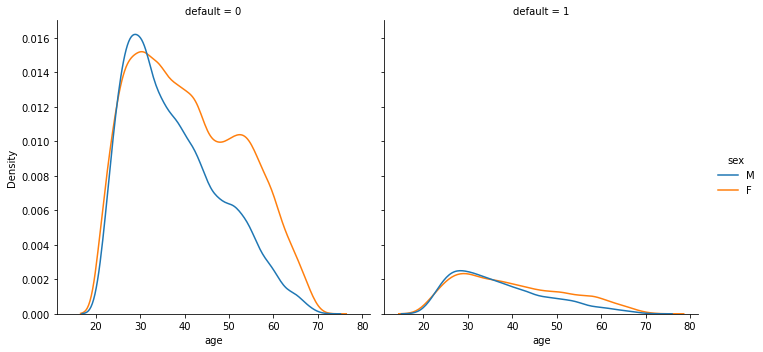

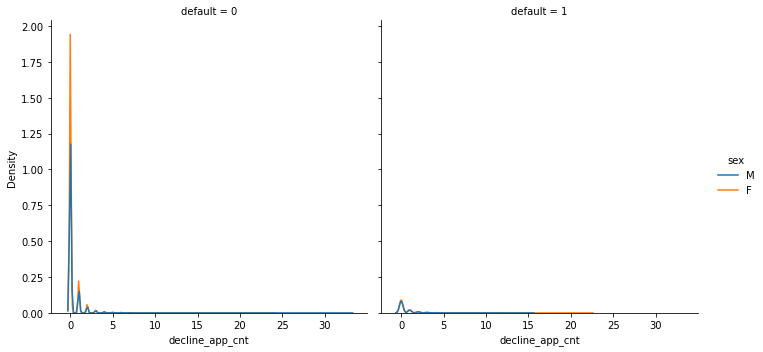

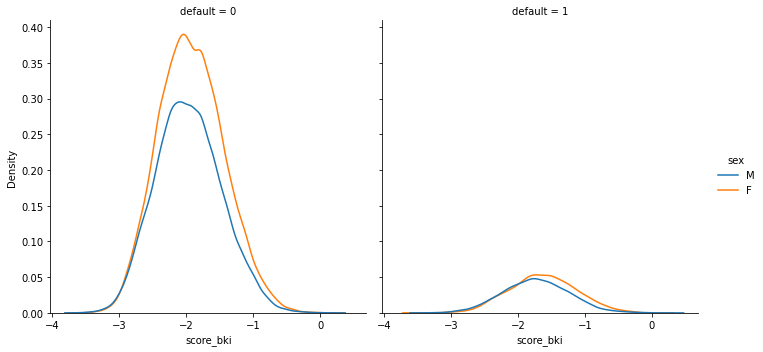

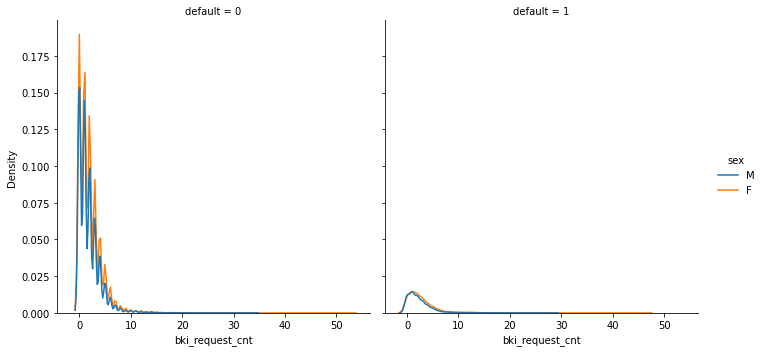

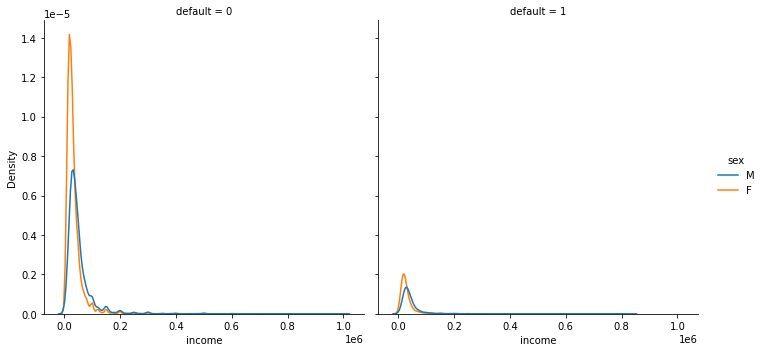

In [104]:
for col in num_cols:
    sns.displot(data=train, x=col, hue="sex", col="default", kind="kde")

Какие можно сделать выводы?
* до 30 лет количество дефолтных клиентов растёт, но одновременно (и гораздо быстрее) растёт и количество платёжеспособных клиентов. В целом в районе 30 лет наблюдается как максимальное число клиентов, так и наибольшая дельта между дефолтными и не дефотлтными клиентами. Женщины раслплачиваются с кредитами лучше мужчин, особенно на рубеже 50 лет - доля недефолтных клиентов этого возраста даже растёт.
* В среднем "хорошие" клиенты старше.
* Основная часть заёмщиков имеет доход до 100000, но доля женщин-заёмщиц с таким доходом почти в 2 раза больше чем мужчин, что, учитывая общее соотношение мужчин и женщин, может говорить о том, что мужчины в среднем имеют более высокий доход. При этом в категории клиентов с доходом около 100000 женщины так же чаще выплачивают кредиты, чем мужчины  


### age

Как было показано выше распределение клиентов по возрастам смещено влево.

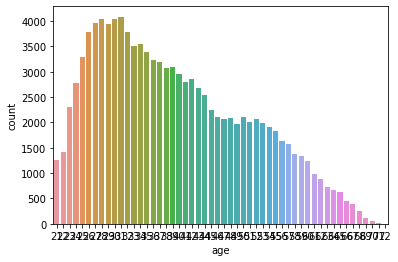

In [105]:
sns.countplot(data=df, x="age");

Переведём age в категориальный признак - сгруппируем возраста в n групп.

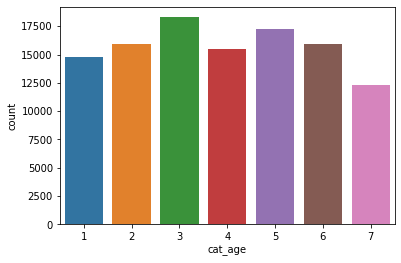

In [106]:
# разобьём всю последовательность значений на группы
# шаг приращения в np.arange - определяет количество итоговых групп
gr = [np.percentile(df.age,i) for i in np.arange(0, 100, 15)]
df['cat_age'] = df['age'].apply(lambda x: feature_to_cat(x,gr))
sns.countplot(data=df, x="cat_age");

### income
Есть как минимум 2 варианта того, как преобразовать признак:

* Преобразовать в категориальный
* Логарифмировать

In [107]:
# Вариант 1: преобразуем в категориальный признак

# gr = [np.percentile(df.income, i) for i in np.arange(0, 100, 10)]
# df['le_income'] = df['income'].apply(lambda x: feature_to_cat(x,gr))
# df = features_labelencoder(df,['le_income'],pref='')
# sns.countplot(data=df, x="le_income");

Можно предварительно посмотреть как будет графически выглядеть логарифмированный признак:

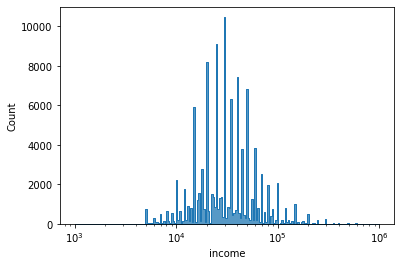

In [108]:
sns.histplot(data=df, x="income", log_scale=True, element="step", fill=True);

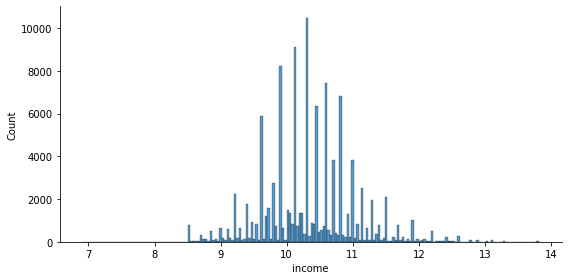

In [109]:
# Вариант 2: логарифмируем
df['income'] = df['income'].apply(lambda w: np.log(w + 1))
sns.displot(data=df, x="income", height=4, aspect=2);

### decline_app_cnt

Так же сильное левое смещение

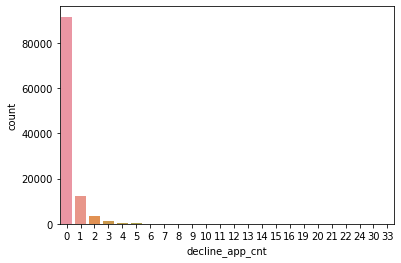

In [110]:
sns.countplot(data=df, x="decline_app_cnt");

Так как в этом параметре нулевых значений подавляющее количество, то преобразуем этот числовой признак в бинарный:
* 0 - не было отказов в кредите
* 1 - были отказы

Но даже после этого наблюдается сильный дисбаланс

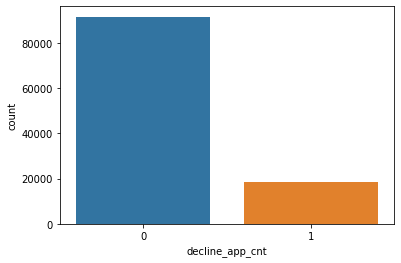

In [111]:
df['decline_app_cnt'] = np.where(df['decline_app_cnt'] < 1, 0, 1)
sns.countplot(data=df, x="decline_app_cnt");

### bki_request_cnt

Данные имеют множество нулевых значений.

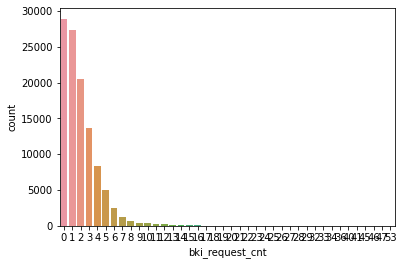

In [112]:
sns.countplot(data=df, x="bki_request_cnt");

Преобразуем признак в категориальный

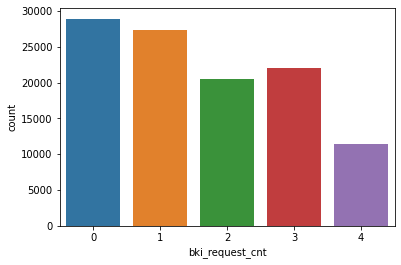

In [113]:
gr = [np.percentile(df.bki_request_cnt,i) for i in np.arange(0, 100, 10)]
df['bki_request_cnt'] = df['bki_request_cnt'].apply(lambda x: feature_to_cat(x,gr))
df = features_labelencoder(df,['bki_request_cnt'],pref='')
sns.countplot(data=df, x="bki_request_cnt");

Оценим корелляцию признаков

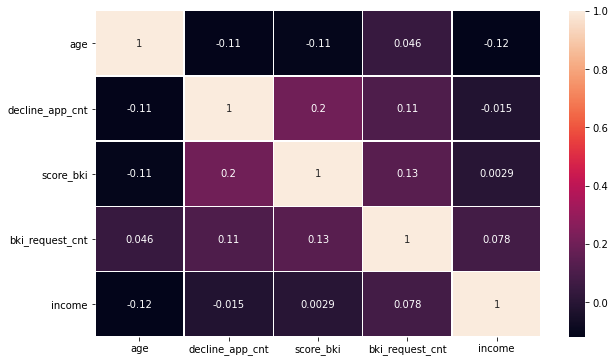

In [114]:
train = df[df['sample'] == 1]
plt.subplots(figsize=(10,6))
sns.heatmap(train[num_cols].corr(),annot=True, linewidths=.5);

Хорошие показатели для будущей модели логрегрессии - сильных корреляций нет

Оценим значимость преобразованных переменных для целевой переменной

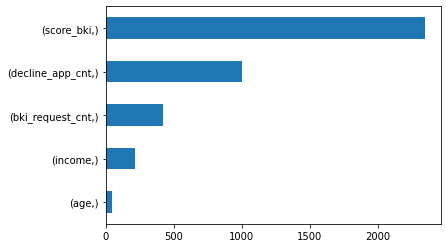

In [115]:
df_num = pd.Series(f_classif(train[num_cols], train['default'])[0], 
                    index=[num_cols])
df_num.sort_values(inplace=True)
df_num.plot(kind='barh');

Наиболее значимые числовые преременные:
* score_bki
* decline_app_cnt

## Категориальные

Посмотрим как распределены значения категориальных признаков по целевой переменной:

* Количество наблюдений

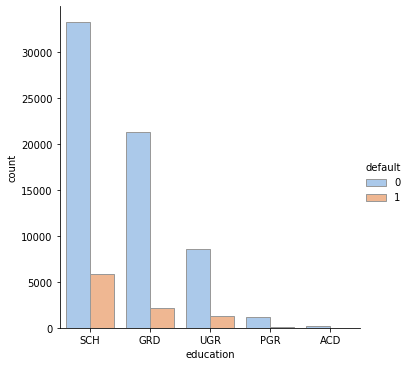

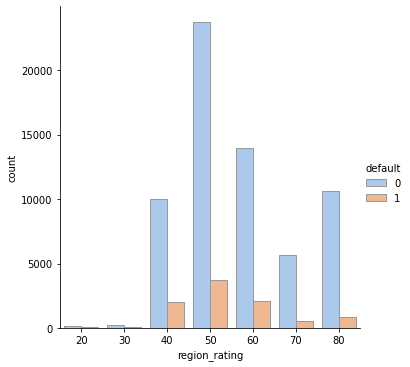

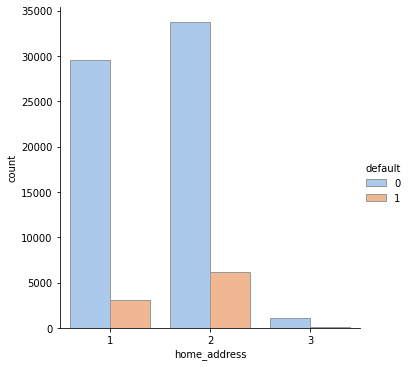

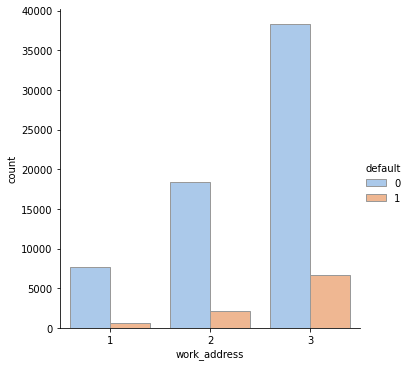

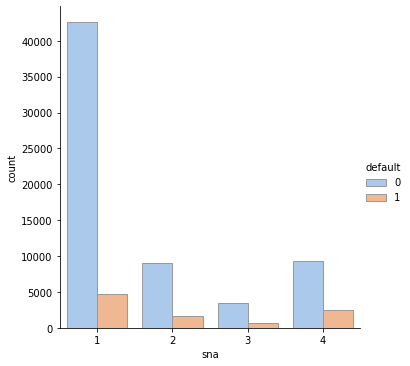

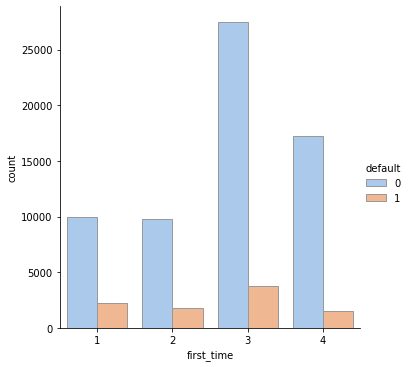

In [116]:
train = df[df['sample'] == 1]
for i in cat_cols:
    sns.catplot(x=i, hue="default", kind="count",
                palette="pastel", edgecolor=".6",
                data=train)

* Частота наблюдений 

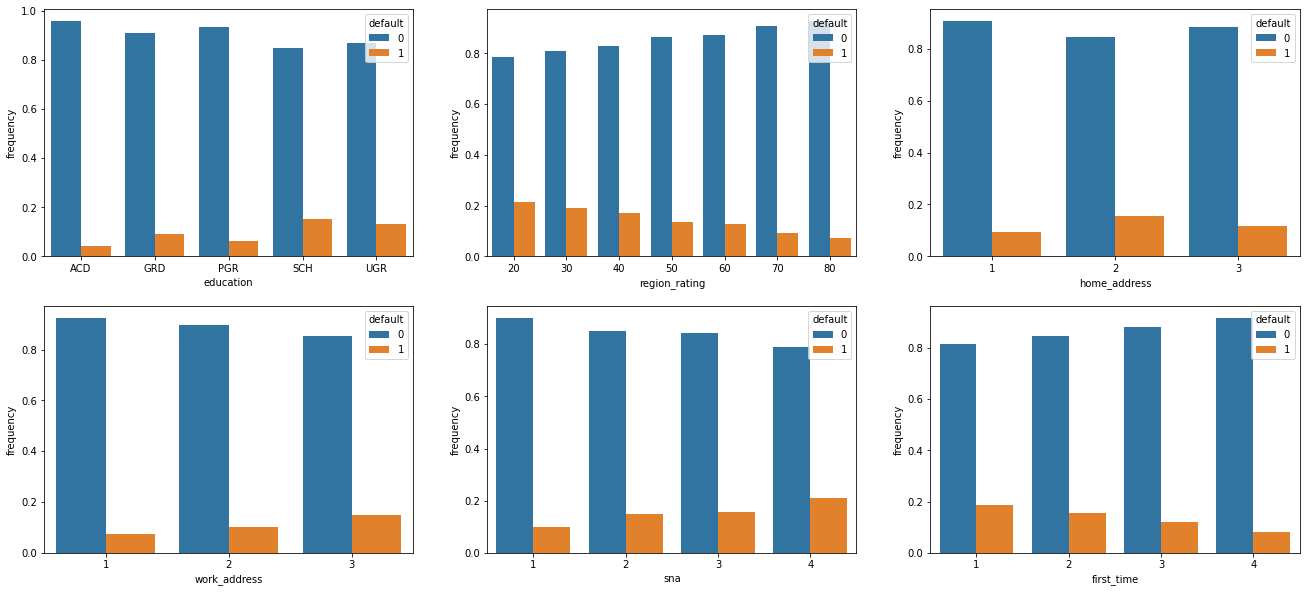

In [117]:
show_frequency(train,'default',cat_cols)

* Видно, что `region_rating` действительно категориальная переменная - чем выше ее значение, тем ниже доля дефолтных клиентов

* `home_address` и `work_address` практически совпадают

* `sna` и `first_time` тоже очень похожи, но зеркально
* доля дефолтных клиентов с самым низким образованием - самая высокая.

Это особенно очевидно, если построить диаграммы по частоте распределения значения признака по целевой переменной.

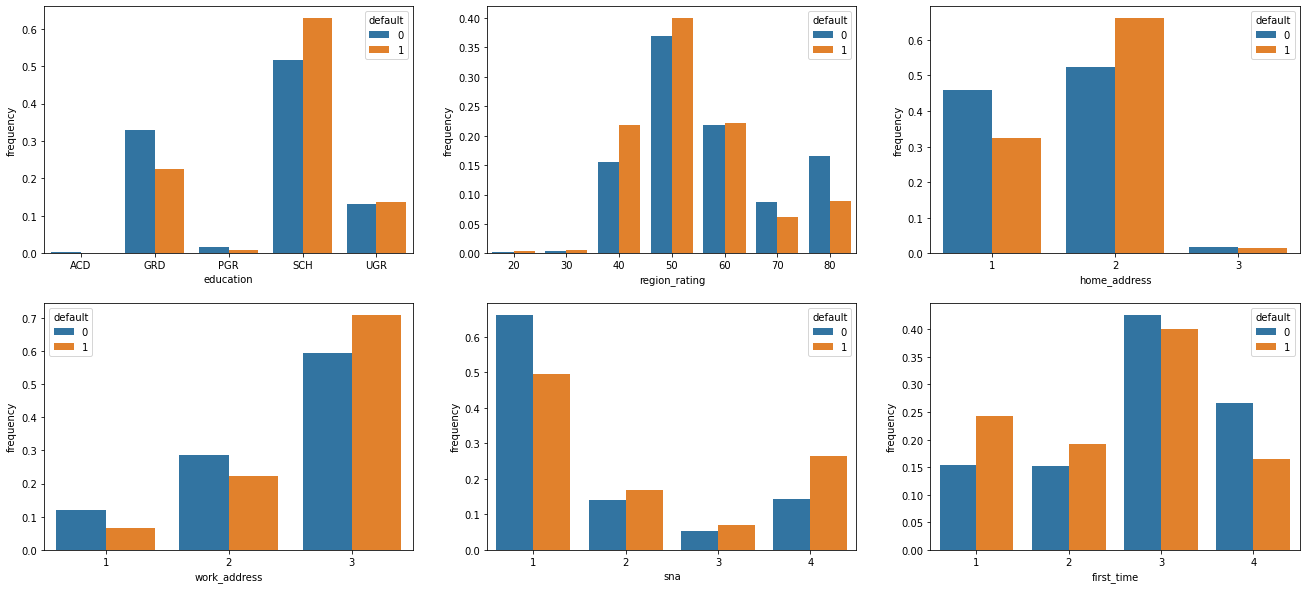

In [118]:
show_frequency(train,'default',cat_cols,calculation_type='target')

Здесь сравниваются дефолт/не дефолт по каждой группе признака
* Больше всего доля дефолтных клиентов среди людей со школьным образованием (SCH), а самая большая доля выплачивающих займы - среди окончивших магистратуру
* **region_rating** - группе с центральным значением (50) принадлежит 40% всех дефолтов по этому признаку и около 37% всех недефолтных случаев. При этом в регионах с высоким рейтингом доля "хороших" клиентов ожидаемо выше

* Болше 60% дефолтов среди всех дефолтных клиентов приходится на клиентов с самым низким образованием и только чуть больше 50% от всех "хороших". Очевидно, что это самая рискованная для банка категория заёмщикаов.
* На этой диаграмме `home_address` и `work_address` выглядят уже не так одинаково, более 70% всех дефолтов `work_address` приходится на 3-ю группу, а в параметре `home_address` группа с самым высоким % дефолта - 2-я
* `region_rating` - группе с центральным значением (50) принадлежит 40% всех дефолтов по этому признаку и около 37% всех недефолтных случаев. При этом в регионах с высоким рейтингом доля "хороших" клиентов ожидаемо выше

* `sna` - на первую группу приходится основная часть заёмщиков, это к тому же единственная группа, в которой доля "хороших" клентов относительно всех "хороших" клиентов по этому признаку больше, чем дефолтных. Можно предположить, что это ранговая категория и к 1-й группе принадлежат клиенты, которые имеют больше всего связей с другими клиентами банка (родственники? поручители?). Этим можно объяснить высокую частоту возврата займа.

* `first_time` - больше всего "хороших" среди всех "хороших" клиентов в 3 и 4 группах. Здесь ситуация в какой-то мере обратная `sna`. Возможно, чем больше ранговое значение категории, тем более "новая" информация о клиенте.



Как связано образование и регион проживания:
* SCH - школа
* GRD - магистратура
* UGR - бакалавриат
* PGR - аспирантура
* ACD - ученая степень

В регионах с высоким рейтингом живет больше всего людей с высоким уровнем образования:

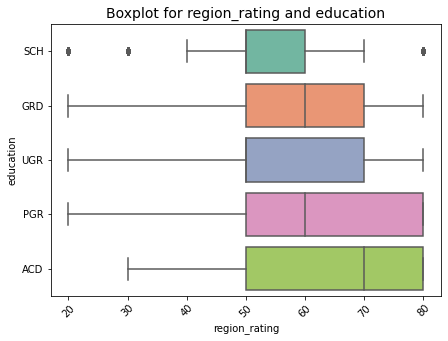

In [119]:
get_boxplot(train,'region_rating','education')

Еще несколько наблюдений:

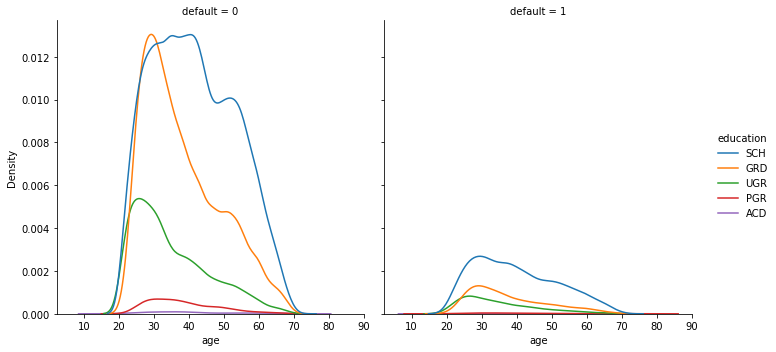

In [120]:
sns.displot(data=train, x="age", hue="education", col="default", kind="kde")

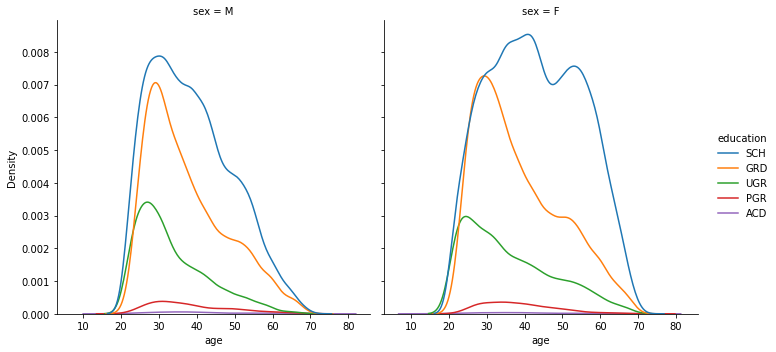

In [121]:
sns.displot(data=train, x="age", hue="education", col="sex", kind="kde")

* Чем выше уровень образования, тем как правило, люди раньше перестают нуждаться в заёмных средствах - после 30 лет наблюдается рост количества заёмщиков только с самым низким уровнем образования.
* Наблюдается любопытная "ступенька" - рост числа займов после 45 лет, особенно характерна для SCH и GRD (школа и магистратура). Возможно это выход на пенсию и покупка недвижимости (особенно это характерно для женщин - на втором графике)? Возможно люди с более высоким уровнем образования менее зависимы от заёмных средств?
* Женщины со школьным образованием распределены более равномерно (как бы странно это не звучало ))). 
* Чаще всего клиентами банка являются женщины в районе 40 лет и мужчины в районе 30 лет.

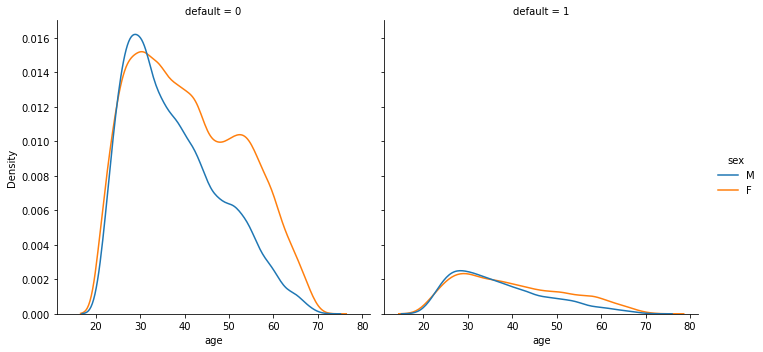

In [122]:
sns.displot(data=train, x="age", hue="sex", col="default", kind="kde");

* Мужчины чаще берут (а так же возвращают и не возвращают) кредиты на рубеже 30 лет, а женщины - после 30 лет.
* Так же после 45 лет наблюдается некоторый рост числа женщин - клиентов банка, которые возвращают кредиты. Этот рост не повторяется среди дефолтных клиентов.

Посмотрим на связь образования, пола и возраста:

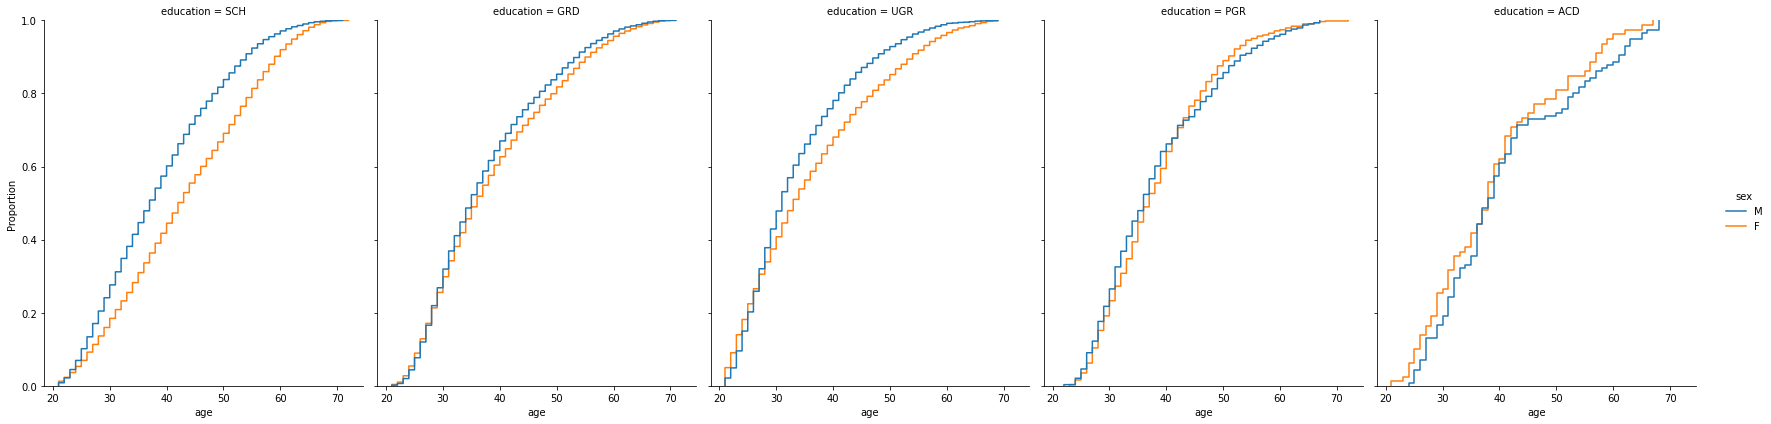

In [123]:
sns.displot(data=train, x="age", hue="sex", col="education",
            kind="ecdf", height=6, aspect=.8,);

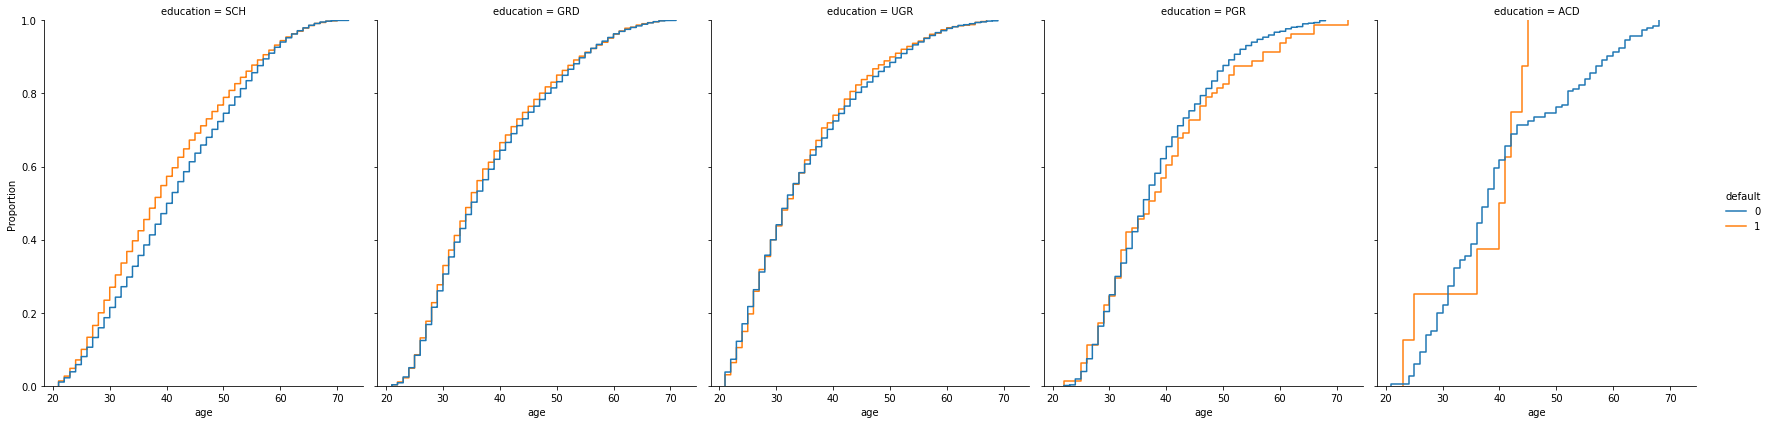

In [124]:
sns.displot(data=train, x="age", hue="default", col="education",
            kind="ecdf", height=6, aspect=.8,);

* Видна тенденция - с ростом уровня образования меняется "портрет" клиента банка. Среди низких уровней образования клиенты-женщины как правило старше мужчин с таким же образованием. Только среди клиентов с ученой степенью клиенты-мужчины старше женщин.

In [125]:
define_featyre_type(df[cat_cols])

1 education: категориальный признак ['GRD' 'SCH' 'UGR' 'PGR' 'ACD'], 0.0% пропусков
2 region_rating: категориальный признак [50 40 80 60 70 20 30], 0.0% пропусков
3 home_address: категориальный признак [1 2 3], 0.0% пропусков
4 work_address: категориальный признак [2 3 1], 0.0% пропусков
5 sna: категориальный признак [1 4 2 3], 0.0% пропусков
6 first_time: категориальный признак [4 3 1 2], 0.0% пропусков


### education

In [126]:
# Закодируем уровень образования
le = LabelEncoder()
le.fit(df['education'])
df['education'] = le.transform(df['education'])

Все категориальные прзнаки выражены числами.
Посмотрим на значимость признаков.

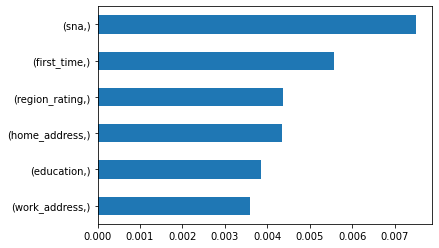

In [127]:
test = df[df['sample'] == 1].copy()
test = pd.Series(mutual_info_classif(test[cat_cols],test['default'],
    discrete_features=True), index=[cat_cols])
test.sort_values(inplace=True)
test.plot(kind='barh');

Оценим корелляцию категориальных признаков

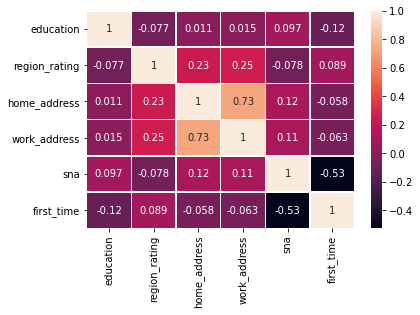

In [128]:
sns.heatmap(df[df['sample'] == 1][cat_cols].corr(),annot=True, linewidths=.5);

* `home_address`  и `work_address` имеют друг с другом довольно высокую корреляцию $0.73$
* `sna` и `first_time` тоже заметно коррелируют $-0,53$. Вдобавок они имеют сильное влияние на целевую переменную.


### home_address - work_address

### sna - first_time


Большую ценность имеет признак sna

Эти параметры имеют сильную взаимную корреляцию

Применим к этим признакам метод главных компонент (PCA)

In [129]:
feature = {'pca_address':['work_address', 'home_address'],
           'pca_sna_time': ['sna', 'first_time']}
for key in feature.keys():
    data = df[feature[key]].values

    # создаём экземпляр Scaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Указываем новую размерность - n_components
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    
    # создаём новый признак
    df[key] = pca_data
    df = df.drop(feature[key],axis=1)

In [130]:
# Корректируем список признаков
cat_cols = set(cat_cols)
m = {'sna', 'first_time','work_address', 'home_address','pca_address','pca_sna_time'}

# множество из элементов, встречающихся в одном множестве, но не встречающиеся в обоих
cat_cols ^= m
cat_cols = list(cat_cols)

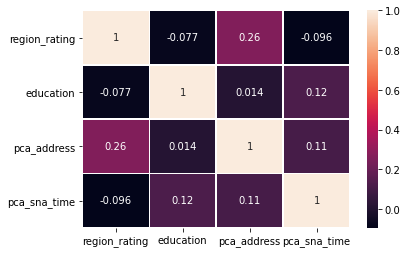

In [131]:
sns.heatmap(df[df['sample'] == 1][cat_cols].corr(),annot=True, linewidths=.5);

## Бинарные

Посмотрим как распределены значения бинарных признаков по целевой переменной:

* Количество наблюдений

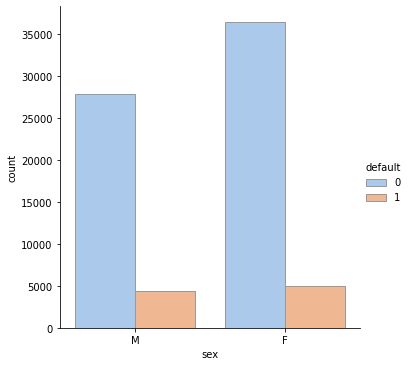

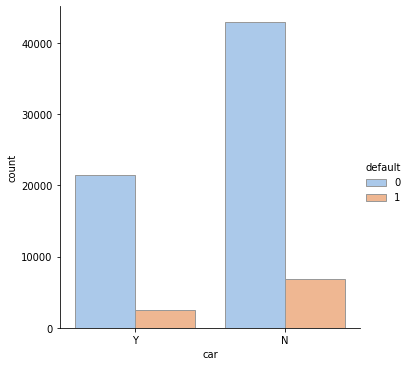

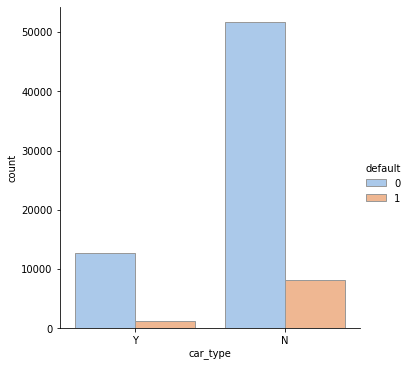

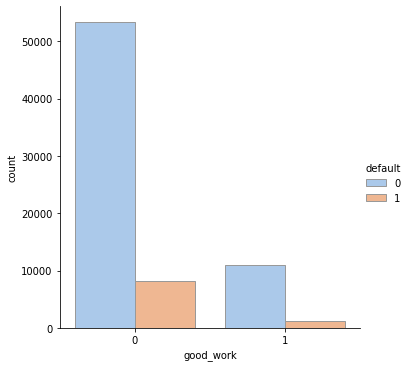

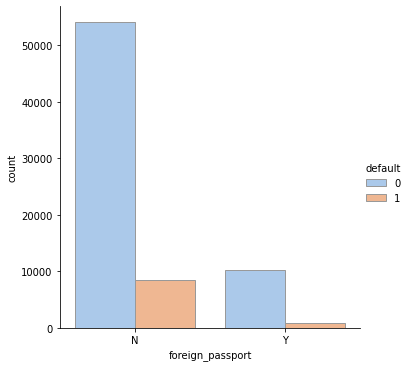

In [132]:
train = df[df['sample'] == 1]
for i in bin_cols:
    sns.catplot(x=i, hue="default", kind="count",
                palette="pastel", edgecolor=".6",
                data=train)

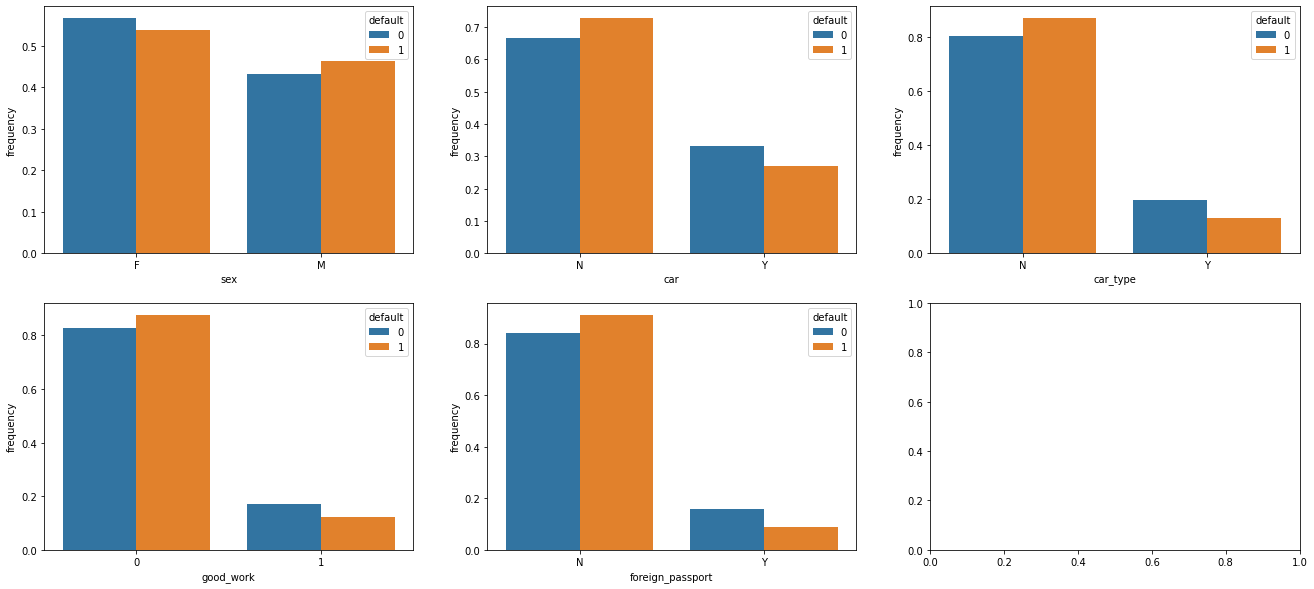

In [133]:
show_frequency(train,'default',bin_cols,calculation_type='target')

Здесь сравниваются дефолт/не дефолт по каждой группе признака 
>например - дефолты среди женщин + дефолты среди мужчин = 100%:
* **sex** - женщины возвращают кредиты лучше мужчин
* **car** - автовладельцы чаще выплачивают займы, чем те у кого нет ммашины
* **car_type** - ладельцы иномарок более кредитоспособны, чем владельцы отечественных авто
* **good_work** - бладатели хорошей работы - более надёжные плательщики
* **foreign_passport** - обладателям загранпаспортов банк охотнее выдаст кредит.

In [134]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,foreign_passport,sample,default,cat_age,pca_address,pca_sna_time
0,74835,2014-03-22,1,1,29,1,1,0,0,-2.271884,3,50,10.819798,0,0,0,2,-1.282573,-1.324902
1,17527,2014-01-24,3,0,39,0,0,1,0,-1.504999,2,50,8.517393,0,0,0,4,-1.282573,1.264673
2,75683,2014-03-23,4,1,50,1,1,0,0,-1.691339,1,50,10.308986,1,0,0,6,-1.282573,-0.624898
3,26883,2014-02-03,3,1,56,0,0,0,0,-2.374182,1,40,9.741027,0,0,0,7,-1.282573,-0.624898
4,28862,2014-02-04,1,0,38,0,0,0,0,-2.487502,0,80,11.695255,0,0,0,4,1.086059,-0.624898


Оценим корелляцию бинарных признаков

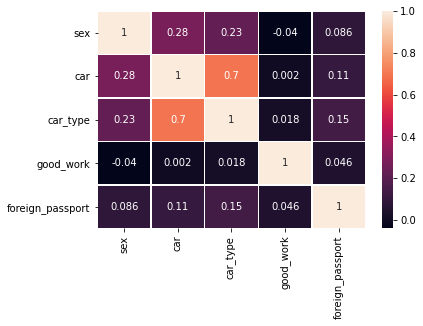

In [135]:
train = df[df['sample'] == 1]
sns.heatmap(train[bin_cols].corr(),annot=True, linewidths=.5);

* `car` имет сильную корреляцию с признаком `car_type`.

Следуя логике и здравому смыслу, возможно стоит объединить эти 2 признака в один категориальный (0 - нет автомобиля, 1 - отечественный автомобиль, 2 - автомобиль-иномарка)

Значение признаков для целевой переменной

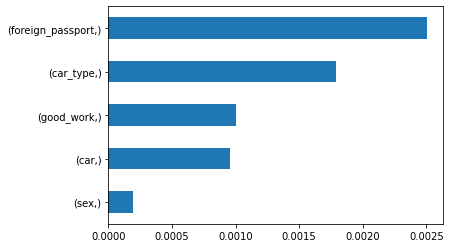

In [136]:
imp_bin = pd.Series(mutual_info_classif(
    train[bin_cols], 
    train['default'],
    discrete_features=True), index=[bin_cols])

imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh');

### car - car_type

Создаим из этих 2-х признаков один категорийный.

Их можно просто просуммировать.

Тогда в категории появится 3 значения: 
* 0 - нет машины (0+0)
* 1 - отечественная машина (1+0)
* 2 - иномарка (1+1)

In [137]:
df['car'] = df['car'] + df['car_type']
df = df.drop(['car_type'], axis=1)

# скорректируем список 
bin_cols.remove('car')
bin_cols.remove('car_type')
cat_cols.append('car')

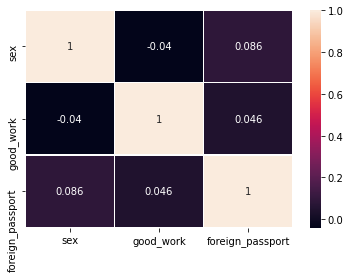

In [138]:
train = df[df['sample'] == 1]
sns.heatmap(train[bin_cols].corr(),annot=True, linewidths=.5);

## Даты

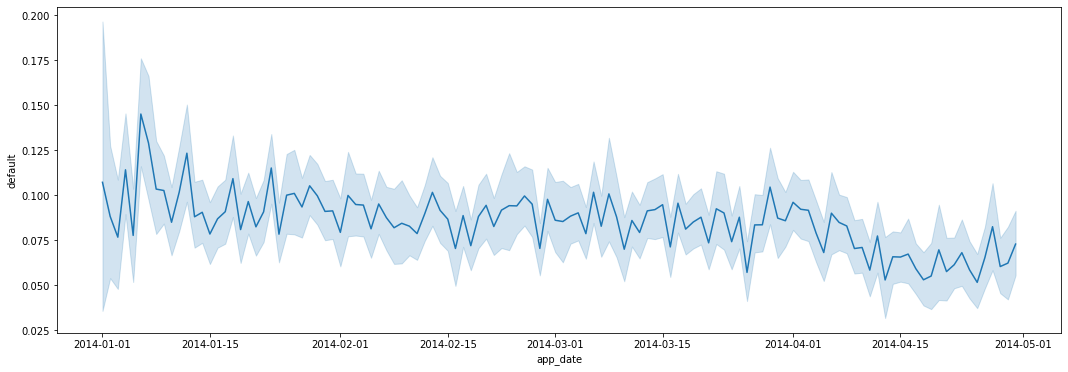

In [139]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(data=df, x="app_date", y="default");

* Видна тенденция снижения количества дефолтных клиентов, то есть связь даты и целевой переменной должна быть.
* Поскольку в датасете представлены данные не за целый год или несколько лет, то выделять в отдельный признак год или месяц не имеет смысла.
* Логичнее преобразовать даты в целые числа, которые будут представлять разницу в днях от минимальной даты в данных - это позволит передать тенденцию изменения от прошлого к будущему

In [140]:
df['app_date'] = (df['app_date'] - df['app_date'].min())/np.timedelta64(1,'D')
num_cols.append('app_date')

Значение признаков

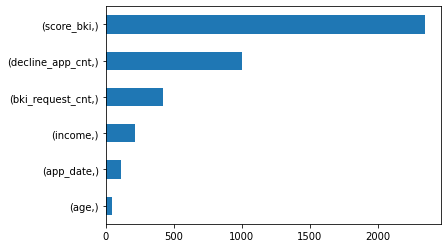

In [141]:
train = df[df['sample'] == 1]
df_num = pd.Series(f_classif(train[num_cols], train['default'])[0], 
                    index=[num_cols])
df_num.sort_values(inplace=True)
df_num.plot(kind='barh');

Кореляция

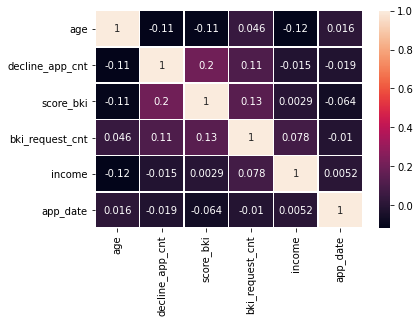

In [142]:
sns.heatmap(train[num_cols].corr(),annot=True, linewidths=.5);

* Признак, обозначающий разницу в днях от минимальной даты оказался более значим, чем возраст клиента.
* Кореляционная матрица показывает хооршие результаты для числовых переменных.

## ИТОГИ

In [143]:
# перенесём изменённый признак age  в категориальные
# cat_age

Построим общую корреляционную матрицу для всех обработанных признаков

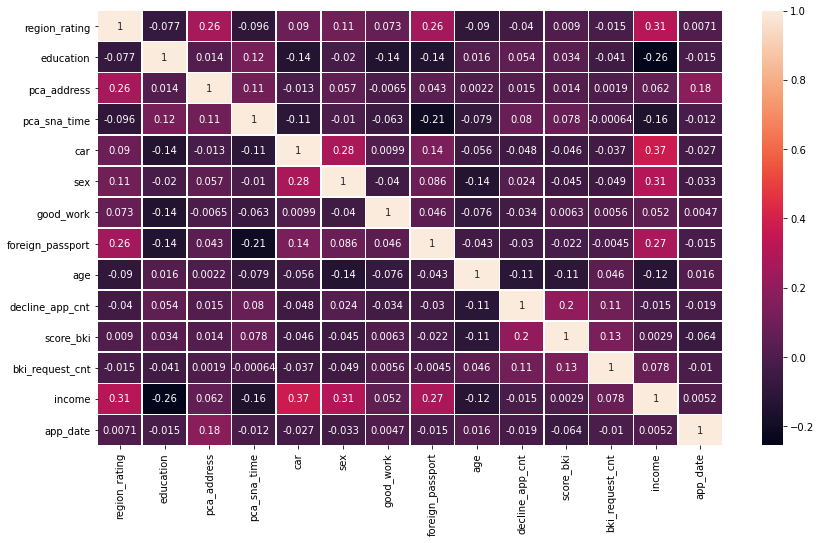

In [144]:
train = df[df['sample'] == 1]
plt.figure(figsize=(14, 8))
sns.heatmap(train[cat_cols + bin_cols + num_cols].corr(),annot=True, linewidths=.5);

Посмотрим на измененные признаки, заново разделим на списки

In [145]:
define_featyre_type(df.drop(['client_id','sample','default'],1))

1 app_date: числовой признак, 0.0% пропусков
2 education: категориальный признак [1 3 4 2 0], 0.0% пропусков
3 sex: бинарный признак [1 0], 0.0% пропусков
4 age: числовой признак, 0.0% пропусков
5 car: категориальный признак [2 0 1], 0.0% пропусков
6 decline_app_cnt: бинарный признак [0 1], 0.0% пропусков
7 good_work: бинарный признак [0 1], 0.0% пропусков
8 score_bki: числовой признак, 0.0% пропусков
9 bki_request_cnt: категориальный признак [3 2 1 0 4], 0.0% пропусков
10 region_rating: категориальный признак [50 40 80 60 70 20 30], 0.0% пропусков
11 income: числовой признак, 0.0% пропусков
12 foreign_passport: бинарный признак [0 1], 0.0% пропусков
13 cat_age: категориальный признак [2 4 6 7 5 3 1], 0.0% пропусков
14 pca_address: числовой признак, 0.0% пропусков
15 pca_sna_time: числовой признак, 0.0% пропусков


In [146]:
# Категориальные
cat_cols = get_list_feature_type(df.drop(
    ['client_id','sample','default'],1),kind='cat') 
# Бинарные
bin_cols = get_list_feature_type(df.drop(
    ['client_id','sample','default'],1),kind='bin') 
# Числовые
num_cols = get_list_feature_type(df.drop(
    ['client_id','sample','default','age'],1),kind='num') 

# Encoding

Готовим данные для ML

In [147]:
# Опять делим датасет
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

# Создание полиномиальных признаков- разные варианты
# lst_poly = ['age', 'bki_request_cnt','income','app_date','score_bki']
# lst_poly = num_cols # хуже
lst_poly = cat_cols + num_cols

pf = PolynomialFeatures(2)
X_poly = pf.fit_transform(train_data[lst_poly].values)

# Бинарные - кодируем
label_encoder = LabelEncoder()

for column in bin_cols:
    train_data[column] = label_encoder.fit_transform(train_data[column])
    
# категориальные - кодируем
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)

# числовые - стандартизируем
X_num = StandardScaler().fit_transform(train_data[num_cols].values)

# Объединяем
X = np.hstack([X_num, train_data[bin_cols].values, X_cat, X_poly])
y = train_data['default'].values

На этом этапе можно еще раз построить модель и сравнить получившиеся метрики

# ML

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


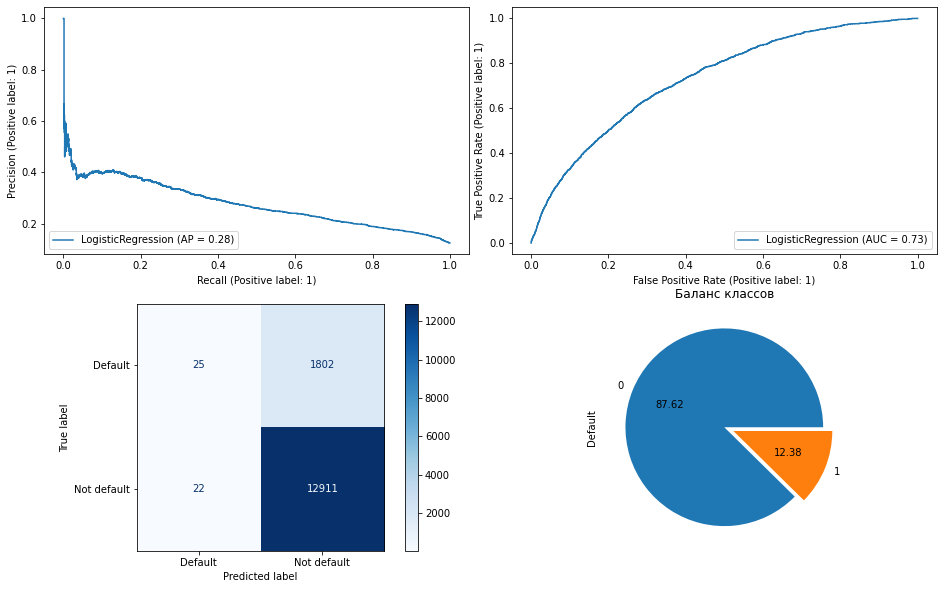

In [148]:
#@title Модель на подготовленных данных { vertical-output: true, form-width: "20%", display-mode: "form" }
use = True #@param {type:"boolean"}
if use == True:

    # Делим на обучающую и валидационнцю выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.20, 
                                                        random_state=RANDOM_SEED)

    # Классифкатор
    lr = LogisticRegression(max_iter=1000)
    # обучаем
    lr.fit(X_train, y_train)
    # предсказываем
    y_pred = lr.predict(X_test)

    # Визуализируем результат
    get_model_plot(lr,X_test,y_test)

    # Сохраним значения метрик
    results = get_metrics(results, lr, X_test,
                        y_test, 'LogisticRegression_(balanced)')
    results

* Показатели улучшились, значит двигаемся в верном направлении, хотя модель ругается на настройках по умолчанию - сходимость не достигается. 
* По-прежнему модель не умеет хорошо определять дефолтных клиентов, а это одна из основных задач. На лицо - переобучение модели
* Балансировка классов должна помочь

# Балансировка выборки

Есть разные способы сбалансировать данные. 

* oversampling — увеличение количества объектов классов-меньшинств.
* undersampling — сокращение количества объектов превалирующих классов.

Применим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/)

Будем последовательно запускать различные алгоритмы балансировки выборки и оценивать их влияние на ркзультат

In [149]:
#@title undersampling - RandomUnderSampler { run: "auto", form-width: "20%" }
use = False #@param {type:"boolean"}

if use == True:

    '''Балансирируем выборку'''
    from imblearn.under_sampling import RandomUnderSampler
    sampling_strategy = 0.8
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy,
                            random_state=RANDOM_SEED)
    X_res, y_res = rus.fit_resample(X, y)

    argument = 'RandomUnderSampler'
    get_class_balance(y, y_res,argument)

In [150]:
#@title oversampling - RandomOverSampler { run: "auto", form-width: "20%" }

use = False #@param {type:"boolean"}

if use == True:

    '''Балансирируем выборку'''
    from imblearn.over_sampling import RandomOverSampler
    sampling_strategy = "not majority"
    ros = RandomOverSampler(sampling_strategy=sampling_strategy,
                            random_state=RANDOM_SEED)
    X_res, y_res = ros.fit_resample(X, y)

    argument = 'RandomOverSampler'
    get_class_balance(y, y_res, argument)

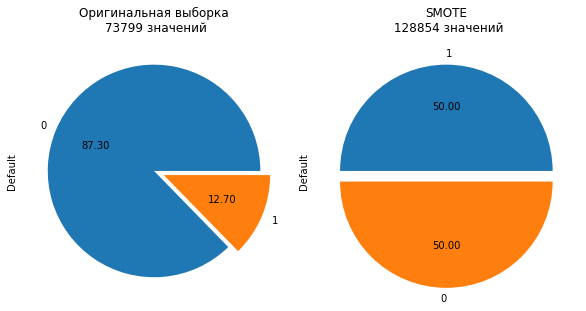

CPU times: user 2.93 s, sys: 996 ms, total: 3.92 s
Wall time: 3.39 s


In [151]:
%%time
#@title oversampling - SMOTE { run: "auto", form-width: "20%" }

use = True #@param {type:"boolean"}

if use == True:
    '''Балансирируем выборку'''

    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=RANDOM_SEED)
    X_res, y_res = sm.fit_resample(X, y)
    argument = 'SMOTE'
    get_class_balance(y,y_res,argument)

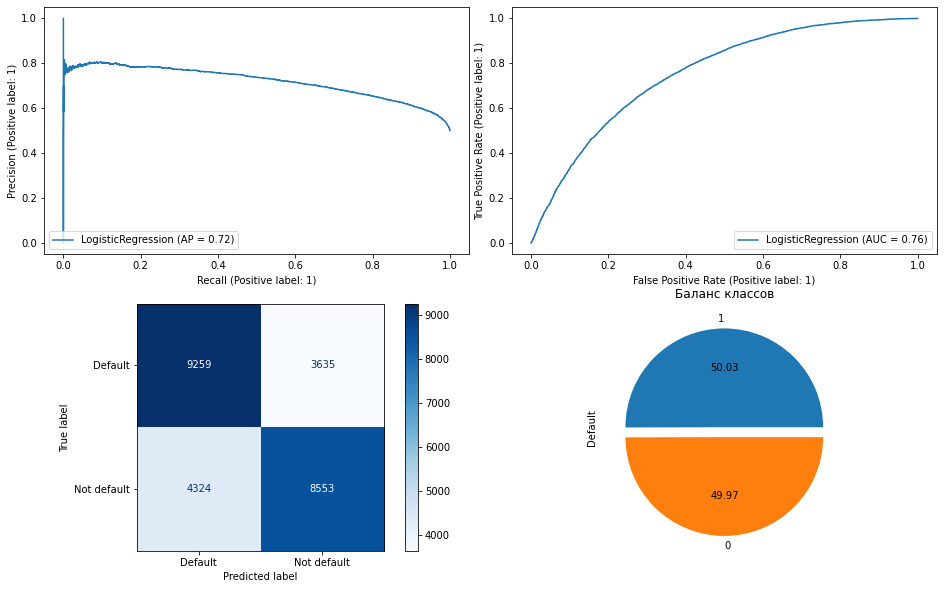

CPU times: user 46.6 s, sys: 428 ms, total: 47.1 s
Wall time: 46.5 s


In [152]:
%%time
#@title Модель c предварительной балансировкой выборки { form-width: "20%", display-mode: "form" }
use = True #@param {type:"boolean"}
if use == True:
    # Делим на обучающую и валидационнцю выборки
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                        test_size=0.20,
                                                        random_state=RANDOM_SEED)

    # Эксперименты

    # # Kaggle 0.73452
    # C = 1637.8937069540646
    # penalty='l1'
    # solver= 'liblinear'

    # 0.73461
    C = 59.94842503189409 
    penalty='l2'
    solver= 'liblinear'


    # модель c подобранными гиперпараметрами
    lr = LogisticRegression(C=C,
                            penalty=penalty,
                            solver= solver,
                            max_iter=800)

    argument =  str(C) + ', ' + penalty + ', ' + solver
    # обучаем
    lr.fit(X_train, y_train)
    # предсказываем
    y_pred = lr.predict(X_test)

    # Визуализируем результат
    get_model_plot(lr,X_test,y_test)

    # Сохраним значения метрик
    results = get_metrics(results, lr, X_test,
                        y_test, 'LogisticRegression_' + argument)

* Балансировка выбоки даёт существенный прирост качества, особенно метрик AP и f1
* Из использованных алгоритмов балансировки лучший результат показал SMOTE, увеличивающий количество миноритарного класса, худший - RandomUnderSampler, уменьшающий мажоритарный. Возможно я не до конца разобрался в них...
* Модель почти в 2 раза больше (лучше) определяет и дефолтных и не дефолтных клиентов, но все равно это еще далеко от идеала.... 
* При всех положительных результаах существенно растёт LogLoss.... Вероятно это можно побороть только настройками гиперпараметров...?

In [153]:
results

,LogLoss,ROC-AUC,Balanced accuracy,Average precision,F1-score
LogisticRegression_Naive,0.370,0.584,0.500,0.160,0.000
LogisticRegression_(balanced),0.336,0.733,0.506,0.278,0.027
"LogisticRegression_59.94842503189409, l2, liblinear",0.583,0.757,0.691,0.719,0.699


In [154]:
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 4)))

MSE: 0.3088


# Гиперпараметры

У нас имеется довольно много признаков и подбор сразу множества гиперпараметров может занять продолжительное время (и заняло...).
Для ускорения этого процесса сначала воспользуемся случайным поиском по сетке.

In [155]:
%%time
#@title Случайный поиск по сетке { run: "auto", form-width: "20%", display-mode: "form" }
use = False #@param {type:"boolean"}

if use == True:
    # Балансируем выборку
    # from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=RANDOM_SEED)
    X_res, y_res = sm.fit_resample(X, y)

    # задаём модель
    model = LogisticRegression(max_iter=1000,
                            random_state=RANDOM_SEED)

    # формируем сетку параметров
    parameters_grid = {'penalty': ['l2','l1'],
                    'solver': ['liblinear','saga'],
                    'C': np.logspace(0, 4, 10)
                    }

    # Можно определить несколько метрик
    # from sklearn.metrics import make_scorer
    # scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
    #            'f1': make_scorer(f1_score),
    #            'logloss': make_scorer(log_loss)}

    scoring = 'f1'
    # Делим на обучающую и валидационнцю выборки  на сбалансированных данных
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                        test_size=0.20,
                                                        random_state=RANDOM_SEED)
    # определяем валидатор
    # Вариант 1
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)

    # Вариант 2 - по умолчанию KFold 5
    # cv = 5

    # Grid search - создаём объект, передаём в него:
    # - модель, сетку параметров, метрику (метрики) и стратегию кросс-валидации
    randomizedgrid_cv = RandomizedSearchCV(model, parameters_grid, 
                                           scoring=scoring, refit=True, 
                                           n_iter=5, cv=cv, 
                                           random_state=RANDOM_SEED)

    randomizedgrid_cv.fit(X_train,y_train)

    print(randomizedgrid_cv.best_estimator_)
    print(randomizedgrid_cv.best_params_)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


Опираясь на эти данные (исключив вероятно худшие параметры) воспользуемся методом GridSearchCV

In [156]:
%%time
#@title GridSearchCV { form-width: "20%", display-mode: "form" }
use = False #@param {type:"boolean"}

if use == True:

    # Гиперпараметры 
 
    # задаём модель
    model = LogisticRegression(max_iter=1000,
                            #    solver = 'liblinear',
                            random_state=RANDOM_SEED)

    # формируем сетку параметров
    parameters_grid = {'penalty': ['l1', 'l2'],
                    'solver':['liblinear', 'sag', 'saga'],
                    'C': np.logspace(0, 4, 10)
                    }

    # Можно определить несколько метрик, для которых будет производиться подбор
    # from sklearn.metrics import make_scorer
    # scoring = {'balanced_accuracy': make_scorer(balanced_accuracy_score),
    #            'f1': make_scorer(f1_score),
    #            'logloss': make_scorer(log_loss)}
    scoring = 'roc_auc'

    # Делим на обучающую и валидационнцю выборки
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                        test_size=0.20,
                                                        random_state=RANDOM_SEED)

    # определяем валидатор
    # Вариант 1
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=RANDOM_SEED)

    # Вариант 2 -  с использованием 5-кратной перекрестной проверки
    # cv = 5

    # Подбор параметров и оценка качества
    # 
    # Grid search - создаём объект, передаём в него:
    # - модель, сетку параметров, метрику (метрики) и стратегию кросс-валидации
    search = GridSearchCV(model, parameters_grid, scoring=scoring, cv=cv, verbose=0)

    search.fit(X_train,y_train)
    print(search.best_estimator_)
    print(search.best_params_)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs




```
* balanced_accuracy 0.6849357080731314
* LogisticRegression(C=1637.8937069540646, max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')
* {'C': 1637.8937069540646, 'penalty': 'l1', 'solver': 'liblinear'}
* 5
```



# Предсказания

In [157]:
#@title Подготовка данных { form-width: "20%" }

# Проделываем необходимые опрерации над тестовой частью выборки

pf = PolynomialFeatures(2)
X_poly = pf.fit_transform(test_data[lst_poly].values)
label_encoder = LabelEncoder()
for column in bin_cols:
    test_data[column] = label_encoder.fit_transform(test_data[column])
X_cat = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)
X_num = StandardScaler().fit_transform(test_data[num_cols].values)
X = np.hstack([X_num, test_data[bin_cols].values, X_cat, X_poly])

# предсказываем на обученной модели
y_pred = lr.predict_proba(X)[:,1]

test_data['default'] = y_pred
submission = test_data[['client_id','default']].copy()
display(submission.sample(10))
display(submission.shape)

,client_id,default
27686,81556,0.053533
29469,23673,0.341880
25856,68705,0.415402
8827,76057,0.274240
9957,61840,0.155110
10637,76477,0.375324
5837,55347,0.141365
17144,33904,0.732049
118,106331,0.264802
3366,80994,0.660251


(36349, 2)

In [158]:
# time_string = time.strftime("%H.%M")
# time_string

In [159]:
# готовим файл
# submission.to_csv(time_string + '_submission.csv', index=False)
submission.to_csv('submission.csv', index=False)